In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import collections
from matplotlib.animation import FFMpegWriter
from matplotlib import animation

from astropy import constants as const
from astropy import units as u

%matplotlib inline

In [ ]:
from read_mist_models import EEP

# Initial Mass Function

$$\frac{dn}{dM} = kM^{-2.35}$$

n = star number density

M = mass

$$k = \text{local stellar density} \approx 0.14 \text{ stars} \text{ pc}^{-3}$$

See:
1. https://en.wikipedia.org/wiki/Stellar_density
2. https://en.wikipedia.org/wiki/Initial_mass_function#cite_note-6

In [ ]:
k = 0.14

In [ ]:
deltam = 0.1
starNumberDensities = []
for m in np.arange(.01,100,0.1):
   # n = k*(1/1.35)*(-(m+deltam)**-1.35+m**-1.35)
    N = k*(m)**-2.35*(deltam)
    starNumberDensities.append(N)
print(starNumberDensities)

plt.plot(np.arange(.01,100,.1), starNumberDensities)
plt.yscale('log')
plt.xscale('log')




In [ ]:
mass_low = 0.1
mass_high = 300

N_stars = 100

# Assume uniformly distributed masses for now
masses = np.random.uniform(mass_low, mass_high, size=N_stars) * u.M_sun

# Mass-Luminosity Relation (MLR)
See: https://en.wikipedia.org/wiki/Mass%E2%80%93luminosity_relation


*   List item

*   List item

1.   List item

1.   List item
2.   List item


2.   List item


*   List item


*   List item


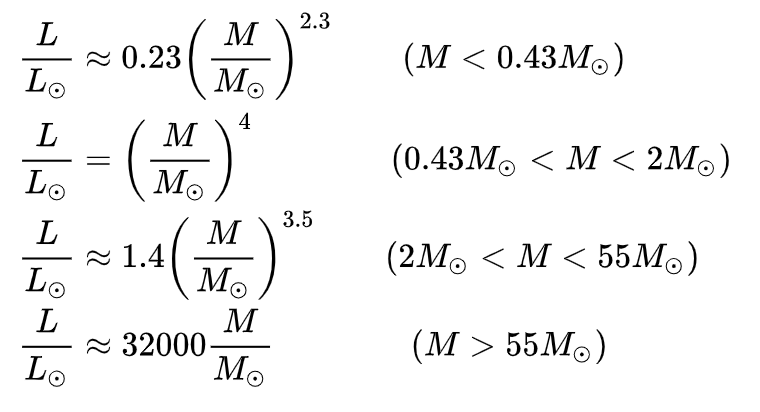

In [ ]:
def mass_luminosity_relation(masses):
    """
    Use a for loop to loop through array of masses, then use the conditions
    above (with if statements) in order to compute the right luminosity in units
    of solar luminosity L_sun.
  ***M is in solar masses***
    """
    output = []
    for M in masses: #appends L of M
        if M < 0.43*const.M_sun:
          output.append(0.23*(M/const.M_sun)**2.3*const.L_sun) 
        elif M>0.43*const.M_sun and M<2*const.M_sun:
          output.append((M/const.M_sun)**4*const.L_sun)
        elif M>2*const.M_sun and M<55*const.M_sun:
          output.append(1.4*(M/const.M_sun)**3.4*const.L_sun)
        else:
          output.append(32000*(M/const.M_sun)*const.L_sun)
    return output
    """
    Parameters
    ==========
    masses : numpy array containing masses in units of solar masses

    Returns
    =======
    luminosities : numpy array containing predicted luminosities using the MLR
    """
print(mass_luminosity_relation(masses))


## Load EEP track models

In [ ]:
import os
import glob

sorted_model_filenames = sorted(
    list(glob.iglob("MIST_models/*.track.eep")),
    key=lambda filename: int(filename.split("/")[-1].split("M")[0])
)
eeps = [EEP(filename) for filename in sorted_model_filenames]

In [ ]:
# Make an interpolated common time scale (common X ticks)
star_ages_union = np.array(sorted(list(set(np.concatenate([eep.eeps["star_age"] for eep in eeps])))))
plt.hist(star_ages_union[star_ages_union < 1e5])

In [ ]:
age_gaps = np.array([
    np.mean(np.array(eep.eeps["star_age"])[1:] - np.array(eep.eeps["star_age"])[:-1])
    for eep in eeps
])

# Calculate min/max star ages, which is the full range that we need to animate
# min_age = np.floor(np.min([np.min(eep.eeps["star_age"]) for eep in eeps]))
min_age = 50
# max_age = np.floor(np.max([np.max(eep.eeps["star_age"]) for eep in eeps]))
max_age = 1e10

n_frames = 500

log_delta_age = (np.log(max_age) - np.log(min_age)) / n_frames
delta_age = (max_age - min_age) // n_frames

In [ ]:
ages = np.arange(min_age, max_age, delta_age)
log_ages = np.arange(np.log(min_age), np.log(max_age), log_delta_age)

In [ ]:
def linear_interpolate(alpha, a, b):
    return alpha * a + (1 - alpha) * b

def get_data_for_age(eeps, star_age):
    data = collections.defaultdict(dict)
    for eep in eeps:
        star_ages = eep.eeps["star_age"]
        closest_idx = np.clip(np.searchsorted(star_ages, star_age), 0, len(star_ages) - 1)
    
        if ((closest_idx == 0 and star_age < star_ages[closest_idx])
            or (closest_idx == len(star_ages) - 1 and star_age > star_ages[closest_idx])):
            Teff = eep.eeps['log_Teff'][closest_idx]
            L = eep.eeps['log_L'][closest_idx]
            M = round(eep.eeps['star_mass'][closest_idx], 1)
        else:
            # Linearly interpolate between the two closest points
            
            star_age_left = star_ages[closest_idx]
            star_age_right = star_ages[closest_idx + 1]

            frac_between = (star_age - star_age_left) / (star_age_right - star_age_left)

            Teff_left = eep.eeps['log_Teff'][closest_idx]
            Teff_right = eep.eeps['log_Teff'][closest_idx + 1]
            L_left = eep.eeps['log_L'][closest_idx]
            L_right = eep.eeps['log_L'][closest_idx + 1]
            M_left = eep.eeps['star_mass'][closest_idx]
            M_right = eep.eeps['star_mass'][closest_idx + 1]
            
            Teff = linear_interpolate(frac_between, Teff_left, Teff_right)
            L = linear_interpolate(frac_between, L_left, L_right)
            M = linear_interpolate(frac_between, M_left, M_right)
            M = round(M, 1)

        data[M]["Teff"] = Teff
        data[M]["L"] = L

    return data

def parse_data_dict(data):
    Ms = sorted(data.keys())
    Ls = np.array([data[M]["L"] for M in Ms])
    Teffs = np.array([data[M]["Teff"] for M in Ms])
    return Teffs, Ls, Ms

# Initilize writer 
metadata = dict(title='2D animation', artist='Matplotlib')
writer = FFMpegWriter(fps=50, metadata=metadata, bitrate=200000)

## SAVE AS MP4 ##
fig, ax = plt.subplots(figsize=(5,5))

with writer.saving(fig, "test2.mp4", dpi=200):
    for log_star_age in log_ages:
        ax.clear() # first clear the figure

        ax.set_xlabel('log(Teff) [K]', fontsize=22)
        ax.set_ylabel('log(L/Lsun)', fontsize=22)

        star_age = np.exp(log_star_age)
        data = get_data_for_age(eeps, star_age)

        Teffs, Ls, Ms = parse_data_dict(data)
        ax.scatter(Teffs, Ls, c=Ms)
        ax.invert_xaxis()

        plt.draw()
        plt.pause(0.005)

        writer.grab_frame() # save the current frame to mp4

In [ ]:
len(star_ages_union)

In [ ]:
eep.eeps["star_mass"]

In [ ]:
eep.eeps["star_age"]

In [ ]:
np.where(eep.eeps["star_age"] == eep.eeps["star_age"][0])[0].item()